<a href="https://colab.research.google.com/github/mairovitzmario/data_science_notebooks/blob/main/pokemon_battles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Load Kaggle Data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
dataset_link = "lmno3418/pokedex-pokemon-data"

In [ ]:
author, name = dataset_link.split('/')[:2]

In [ ]:
print(author)

lmno3418


In [ ]:
!kaggle datasets download -d {dataset_link}

Dataset URL: https://www.kaggle.com/datasets/lmno3418/pokedex-pokemon-data
License(s): CC0-1.0
pokedex-pokemon-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_filename = f"/content/{name}.zip"

# Unzip the dataset
!unzip -q {zip_filename} -d /content/{name}

replace /content/pokedex-pokemon-data/final_combats.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/pokedex-pokemon-data/final_combats.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# 0. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
import math

# 1. Clean and Explore Data

In [ ]:
df_stats = pd.read_csv('/content/pokedex-pokemon-data/final_pokemon.csv')
df_combats = pd.read_csv('/content/pokedex-pokemon-data/final_combats.csv')

In [ ]:
df_stats.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,height,weight,base_experience,sprites
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,7,69,64,{'normal': 'http://img.pokemondb.net/sprites/b...
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,10,130,142,{'normal': 'http://img.pokemondb.net/sprites/b...
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,20,1000,236,{'normal': 'http://img.pokemondb.net/sprites/b...
3,5,Charmander,Fire,Normal,39,52,43,60,50,65,1,False,6,85,62,{'normal': 'http://img.pokemondb.net/sprites/b...
4,6,Charmeleon,Fire,Normal,58,64,58,80,65,80,1,False,11,190,142,{'normal': 'http://img.pokemondb.net/sprites/b...


In [ ]:
df_combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [ ]:
df_stats.rename(columns={'#':'id'}, inplace=True)

In [ ]:
df_stats.head(1)

,id,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,height,weight,base_experience,sprites
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,7,69,64,{'normal': 'http://img.pokemondb.net/sprites/b...


In [ ]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               697 non-null    int64 
 1   Name             697 non-null    object
 2   Type 1           697 non-null    object
 3   Type 2           697 non-null    object
 4   HP               697 non-null    int64 
 5   Attack           697 non-null    int64 
 6   Defense          697 non-null    int64 
 7   Sp. Atk          697 non-null    int64 
 8   Sp. Def          697 non-null    int64 
 9   Speed            697 non-null    int64 
 10  Generation       697 non-null    int64 
 11  Legendary        697 non-null    bool  
 12  height           697 non-null    int64 
 13  weight           697 non-null    int64 
 14  base_experience  697 non-null    int64 
 15  sprites          697 non-null    object
dtypes: bool(1), int64(11), object(4)
memory usage: 82.5+ KB


In [ ]:
df_stats.isna().sum().sum()

np.int64(0)

In [ ]:
df_combats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38054 entries, 0 to 38053
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   38054 non-null  int64
 1   Second_pokemon  38054 non-null  int64
 2   Winner          38054 non-null  int64
dtypes: int64(3)
memory usage: 892.0 KB


In [ ]:
df_combats.isna().sum().sum()

np.int64(0)

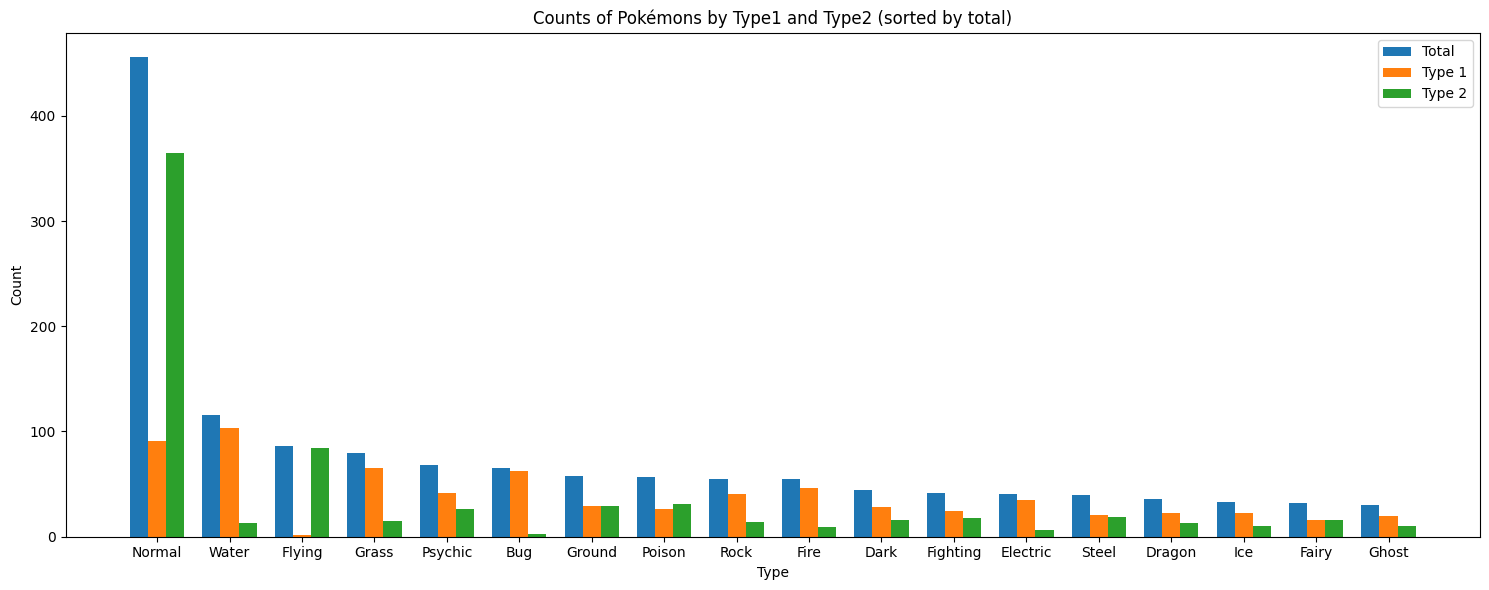

In [ ]:
type1_counts = df_stats['Type 1'].value_counts().sort_index()
type2_counts = df_stats['Type 2'].value_counts().sort_index()

all_types = sorted(set(type1_counts.index) | set(type2_counts.index))

type1_counts = type1_counts.reindex(all_types, fill_value=0)
type2_counts = type2_counts.reindex(all_types, fill_value=0)
sum_counts = type1_counts + type2_counts

# Sort by total counts descending
sorted_idx = sum_counts.sort_values(ascending=False).index

type1_counts = type1_counts.reindex(sorted_idx)
type2_counts = type2_counts.reindex(sorted_idx)
sum_counts = sum_counts.reindex(sorted_idx)
all_types = list(sorted_idx)

x = np.arange(len(all_types))
width = 0.25

fig, ax = plt.subplots(figsize=(15,6))
bars_total = ax.bar(x - width, sum_counts, width, label='Total')
bars1 = ax.bar(x, type1_counts, width, label='Type 1')
bars2 = ax.bar(x + width, type2_counts, width, label='Type 2')

ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.set_title('Counts of Pokémons by Type1 and Type2 (sorted by total)')
ax.set_xticks(x)
ax.set_xticklabels(all_types, rotation=0)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
df_stats['Types'] = df_stats['Type 1'] + ' ' + df_stats['Type 2']

In [ ]:
df_stats['Types'].value_counts().head(20)

,count
Types,
Normal Normal,60
Water Normal,56
Grass Normal,32
Psychic Normal,30
Fire Normal,29
Electric Normal,28
Normal Flying,22
Fighting Normal,19
Bug Normal,17


In [ ]:
df_combats.head(1)

,First_pokemon,Second_pokemon,Winner
0,266,298,298


## Merge the datasets

In [ ]:
df1 = pd.merge(df_stats, df_combats, left_on='id', right_on='First_pokemon', how='right', suffixes=('_first', ''))

In [ ]:
df1.head()

,id,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,height,weight,base_experience,sprites,Types,First_pokemon,Second_pokemon,Winner
0,266,Larvitar,Rock,Ground,50,64,50,45,50,41,2,False,6,720,60,{'normal': 'http://img.pokemondb.net/sprites/b...,Rock Ground,266,298,298
1,702,Virizion,Grass,Fighting,91,90,72,90,129,108,5,True,20,2000,261,{'normal': 'http://img.pokemondb.net/sprites/b...,Grass Fighting,702,701,701
2,191,Togetic,Fairy,Flying,55,40,85,80,105,40,2,False,6,32,142,{'normal': 'http://img.pokemondb.net/sprites/b...,Fairy Flying,191,668,668
3,237,Slugma,Fire,Normal,40,40,40,70,40,20,2,False,7,350,50,{'normal': 'http://img.pokemondb.net/sprites/b...,Fire Normal,237,683,683
4,151,Omastar,Rock,Water,70,60,125,115,70,55,1,False,10,350,173,{'normal': 'http://img.pokemondb.net/sprites/b...,Rock Water,151,231,151


In [ ]:
df = pd.merge(df1, df_stats, left_on='Second_pokemon', right_on='id', how='left', suffixes=('_first', '_second'))

In [ ]:
df.columns

Index(['id_first', 'Name_first', 'Type 1_first', 'Type 2_first', 'HP_first',
       'Attack_first', 'Defense_first', 'Sp. Atk_first', 'Sp. Def_first',
       'Speed_first', 'Generation_first', 'Legendary_first', 'height_first',
       'weight_first', 'base_experience_first', 'sprites_first', 'Types_first',
       'First_pokemon', 'Second_pokemon', 'Winner', 'id_second', 'Name_second',
       'Type 1_second', 'Type 2_second', 'HP_second', 'Attack_second',
       'Defense_second', 'Sp. Atk_second', 'Sp. Def_second', 'Speed_second',
       'Generation_second', 'Legendary_second', 'height_second',
       'weight_second', 'base_experience_second', 'sprites_second',
       'Types_second'],
      dtype='object')

In [ ]:
(df['First_pokemon'] == df_combats['First_pokemon']).sum() - df.shape[0]

np.int64(0)

In [ ]:
(df['First_pokemon'] == df['id_first']).sum() - df.shape[0]

np.int64(0)

In [ ]:
(df['Second_pokemon'] == df_combats['Second_pokemon']).sum() - df.shape[0]

np.int64(0)

In [ ]:
df.drop(columns=['First_pokemon', 'Second_pokemon'], inplace=True)

In [ ]:
df.columns

Index(['id_first', 'Name_first', 'Type 1_first', 'Type 2_first', 'HP_first',
       'Attack_first', 'Defense_first', 'Sp. Atk_first', 'Sp. Def_first',
       'Speed_first', 'Generation_first', 'Legendary_first', 'height_first',
       'weight_first', 'base_experience_first', 'sprites_first', 'Types_first',
       'Winner', 'id_second', 'Name_second', 'Type 1_second', 'Type 2_second',
       'HP_second', 'Attack_second', 'Defense_second', 'Sp. Atk_second',
       'Sp. Def_second', 'Speed_second', 'Generation_second',
       'Legendary_second', 'height_second', 'weight_second',
       'base_experience_second', 'sprites_second', 'Types_second'],
      dtype='object')

## Feature engineering

In [ ]:
df_old = df.copy()

In [ ]:
df[['Winner', 'id_first', 'id_second']].head()

,Winner,id_first,id_second
0,298,266,298
1,701,702,701
2,668,191,668
3,683,237,683
4,151,151,231


In [ ]:
df['Winner'] = np.where(df['Winner'] == df['id_first'], 1, 0)

In [ ]:
df.columns

Index(['id_first', 'Name_first', 'Type 1_first', 'Type 2_first', 'HP_first',
       'Attack_first', 'Defense_first', 'Sp. Atk_first', 'Sp. Def_first',
       'Speed_first', 'Generation_first', 'Legendary_first', 'height_first',
       'weight_first', 'base_experience_first', 'sprites_first', 'Types_first',
       'Winner', 'id_second', 'Name_second', 'Type 1_second', 'Type 2_second',
       'HP_second', 'Attack_second', 'Defense_second', 'Sp. Atk_second',
       'Sp. Def_second', 'Speed_second', 'Generation_second',
       'Legendary_second', 'height_second', 'weight_second',
       'base_experience_second', 'sprites_second', 'Types_second'],
      dtype='object')

In [ ]:
dropped_columns_template = ['id', 'Name', 'Generation', 'sprites', 'Types']
dropped_columns = [x + suffix for x in dropped_columns_template for suffix in ['_first', '_second']]
dropped_columns

['id_first',
 'id_second',
 'Name_first',
 'Name_second',
 'Generation_first',
 'Generation_second',
 'sprites_first',
 'sprites_second',
 'Types_first',
 'Types_second']

In [ ]:
df.drop(columns=dropped_columns, inplace=True)

In [ ]:
df.columns

Index(['Type 1_first', 'Type 2_first', 'HP_first', 'Attack_first',
       'Defense_first', 'Sp. Atk_first', 'Sp. Def_first', 'Speed_first',
       'Legendary_first', 'height_first', 'weight_first',
       'base_experience_first', 'Winner', 'Type 1_second', 'Type 2_second',
       'HP_second', 'Attack_second', 'Defense_second', 'Sp. Atk_second',
       'Sp. Def_second', 'Speed_second', 'Legendary_second', 'height_second',
       'weight_second', 'base_experience_second'],
      dtype='object')

In [ ]:
stats_columns = ['HP','Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'base_experience', 'height', 'weight']

In [ ]:
for feature in stats_columns:
    df[feature + '_diff'] = df[feature + '_first'] - df[feature + '_second']

In [ ]:
df[[col for col in df.columns if col.endswith('_diff')]].head()


,HP_diff,Attack_diff,Defense_diff,Sp. Atk_diff,Sp. Def_diff,Speed_diff,base_experience_diff,height_diff,weight_diff
0,-20,-6,10,-15,10,-19,-59,-4,440
1,0,-39,-18,18,39,0,0,1,-600
2,-20,-35,10,-45,10,0,-28,-4,-313
3,-37,-80,-50,10,-50,-28,-120,-9,-1040
4,50,50,-105,105,-160,50,-4,4,145


In [ ]:
df[['Legendary_first', 'Legendary_second']].head()

,Legendary_first,Legendary_second
0,False,False
1,True,True
2,False,False
3,False,False
4,False,False


In [ ]:
stats_columns_diff = [x + '_diff' for x in stats_columns]
correlation_cols = stats_columns_diff + ['Legendary_first', 'Legendary_second', 'Winner']

In [ ]:
df['Legendary_first'] = df['Legendary_first'].astype(int)
df['Legendary_second'] = df['Legendary_second'].astype(int)

In [ ]:
df[['Legendary_first', 'Legendary_second']].head()

,Legendary_first,Legendary_second
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


In [ ]:
df['legendary_diff'] = df['Legendary_first'] - df['Legendary_second']

## More visualization

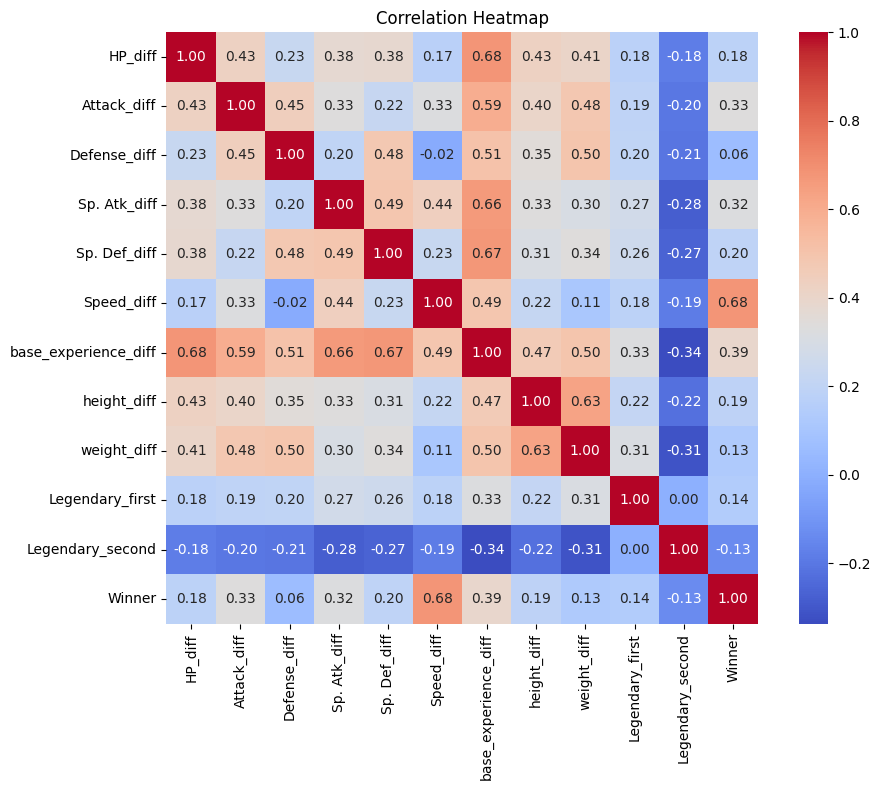

In [ ]:
corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## Pokemon types effectiveness

In [ ]:
TYPE_CHART = {
    "Normal":    {"Rock": 0.5, "Ghost": 0.0, "Steel": 0.5},
    "Fire":      {"Fire": 0.5, "Water": 0.5, "Grass": 2.0, "Ice": 2.0, "Bug": 2.0, "Rock": 0.5, "Dragon": 0.5, "Steel": 2.0},
    "Water":     {"Fire": 2.0, "Water": 0.5, "Grass": 0.5, "Ground": 2.0, "Rock": 2.0, "Dragon": 0.5},
    "Electric":  {"Water": 2.0, "Electric": 0.5, "Grass": 0.5, "Ground": 0.0, "Flying": 2.0, "Dragon": 0.5},
    "Grass":     {"Fire": 0.5, "Water": 2.0, "Grass": 0.5, "Poison": 0.5, "Ground": 2.0, "Flying": 0.5, "Bug": 0.5, "Rock": 2.0, "Dragon": 0.5, "Steel": 0.5},
    "Ice":       {"Fire": 0.5, "Water": 0.5, "Grass": 2.0, "Ice": 0.5, "Ground": 2.0, "Flying": 2.0, "Dragon": 2.0, "Steel": 0.5},
    "Fighting":  {"Normal": 2.0, "Ice": 2.0, "Poison": 0.5, "Flying": 0.5, "Psychic": 0.5, "Bug": 0.5, "Rock": 2.0, "Ghost": 0.0, "Dark": 2.0, "Steel": 2.0, "Fairy": 0.5},
    "Poison":    {"Grass": 2.0, "Poison": 0.5, "Ground": 0.5, "Rock": 0.5, "Ghost": 0.5, "Steel": 0.0, "Fairy": 2.0},
    "Ground":    {"Fire": 2.0, "Electric": 2.0, "Grass": 0.5, "Poison": 2.0, "Flying": 0.0, "Bug": 0.5, "Rock": 2.0, "Steel": 2.0},
    "Flying":    {"Electric": 0.5, "Grass": 2.0, "Fighting": 2.0, "Bug": 2.0, "Rock": 0.5, "Steel": 0.5},
    "Psychic":   {"Fighting": 2.0, "Poison": 2.0, "Psychic": 0.5, "Dark": 0.0, "Steel": 0.5},
    "Bug":       {"Fire": 0.5, "Grass": 2.0, "Fighting": 0.5, "Poison": 0.5, "Flying": 0.5, "Psychic": 2.0, "Ghost": 0.5, "Dark": 2.0, "Steel": 0.5, "Fairy": 0.5},
    "Rock":      {"Fire": 2.0, "Ice": 2.0, "Fighting": 0.5, "Ground": 0.5, "Flying": 2.0, "Bug": 2.0, "Steel": 0.5},
    "Ghost":     {"Normal": 0.0, "Psychic": 2.0, "Ghost": 2.0, "Dark": 0.5},
    "Dragon":    {"Dragon": 2.0, "Steel": 0.5, "Fairy": 0.0},
    "Dark":      {"Fighting": 0.5, "Psychic": 2.0, "Ghost": 2.0, "Dark": 0.5, "Fairy": 0.5},
    "Steel":     {"Fire": 0.5, "Water": 0.5, "Electric": 0.5, "Ice": 2.0, "Rock": 2.0, "Fairy": 2.0, "Steel": 0.5},
    "Fairy":     {"Fire": 0.5, "Fighting": 2.0, "Poison": 0.5, "Dragon": 2.0, "Dark": 2.0, "Steel": 0.5}
}


In [ ]:
def calc_effectiveness(attacking_types, defending_types, type_chart):
    multiplier = 1.0
    for atk in attacking_types:
        for dfn in defending_types:
            multiplier *= type_chart.get(atk, {}).get(dfn, 1.0)
    return multiplier

In [ ]:
def row_effectiveness_first(row):
    atk_types = [row['Type 1_first'], row['Type 2_first']]
    def_types = [row['Type 1_second'], row['Type 2_second']]
    return calc_effectiveness(atk_types, def_types, TYPE_CHART)

df['type_effectiveness_first'] = df.apply(row_effectiveness_first, axis=1)


In [ ]:
def row_effectiveness_second(row):
    atk_types = [row['Type 1_second'], row['Type 2_second']]
    def_types = [row['Type 1_first'], row['Type 2_first']]
    return calc_effectiveness(atk_types, def_types, TYPE_CHART)

df['type_effectiveness_second'] = df.apply(row_effectiveness_second, axis=1)


In [ ]:
types_list = ['Type 1_first',  'Type 2_first' ,'Type 1_second','Type 2_second','type_effectiveness_first', 'type_effectiveness_second' ]

In [ ]:
df[types_list].head()

,Type 1_first,Type 2_first,Type 1_second,Type 2_second,type_effectiveness_first,type_effectiveness_second
0,Rock,Ground,Grass,Dark,0.5,4.0
1,Grass,Fighting,Rock,Fighting,4.0,0.5
2,Fairy,Flying,Psychic,Normal,1.0,1.0
3,Fire,Normal,Dragon,Normal,0.5,1.0
4,Rock,Water,Bug,Rock,4.0,1.0


In [ ]:
types_list.append('type_diff')

In [ ]:
df['type_diff'] = df['type_effectiveness_first'] / df['type_effectiveness_second']

In [ ]:
df['type_diff'] = np.where(df['type_diff'] == np.inf , 512, df['type_diff'])

In [ ]:
df[types_list].head()

,Type 1_first,Type 2_first,Type 1_second,Type 2_second,type_effectiveness_first,type_effectiveness_second,type_diff
0,Rock,Ground,Grass,Dark,0.5,4.0,0.125
1,Grass,Fighting,Rock,Fighting,4.0,0.5,8.000
2,Fairy,Flying,Psychic,Normal,1.0,1.0,1.000
3,Fire,Normal,Dragon,Normal,0.5,1.0,0.500
4,Rock,Water,Bug,Rock,4.0,1.0,4.000


In [ ]:
numeric_types_list = [x for x in types_list if x not in ['Type 1_first',  'Type 2_first' ,'Type 1_second','Type 2_second']]

In [ ]:
numeric_types_list

['type_effectiveness_first', 'type_effectiveness_second', 'type_diff']

In [ ]:
df[numeric_types_list].isna().sum()

,0
type_effectiveness_first,0
type_effectiveness_second,0
type_diff,1820


In [ ]:
df[df[numeric_types_list].isna().any(axis=1)][types_list]

,Type 1_first,Type 2_first,Type 1_second,Type 2_second,type_effectiveness_first,type_effectiveness_second,type_diff
86,Fire,Normal,Ghost,Fire,0.0,0.0,NaN
105,Normal,Flying,Ghost,Dark,0.0,0.0,NaN
116,Psychic,Normal,Ghost,Grass,0.0,0.0,NaN
136,Ghost,Flying,Fighting,Normal,0.0,0.0,NaN
162,Ghost,Fire,Fairy,Normal,0.0,0.0,NaN
...,...,...,...,...,...,...,...
37953,Normal,Normal,Dark,Ghost,0.0,0.0,NaN
37954,Water,Normal,Ghost,Poison,0.0,0.0,NaN
38003,Fire,Normal,Ghost,Normal,0.0,0.0,NaN
38008,Electric,Normal,Ghost,Poison,0.0,0.0,NaN


In [ ]:
df['type_diff'] = df['type_diff'].fillna(1)

<Axes: >

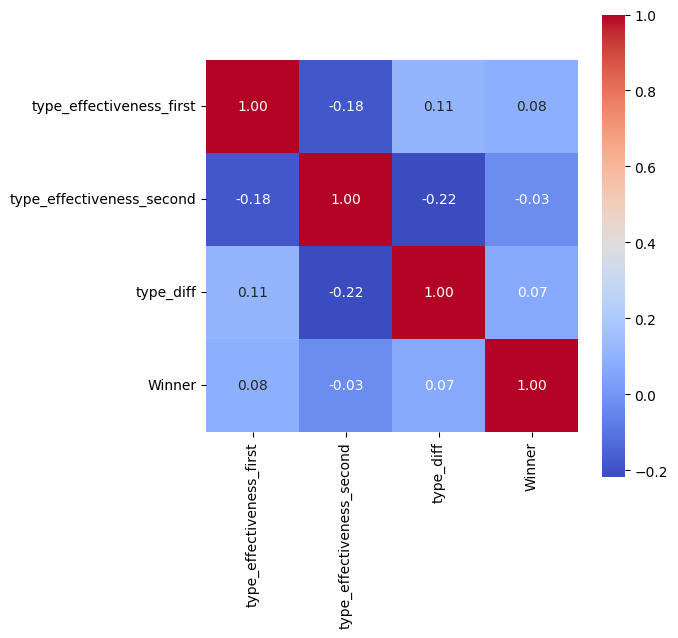

In [ ]:
corr_matrix = df[['type_effectiveness_first', 'type_effectiveness_second', 'type_diff', 'Winner']].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

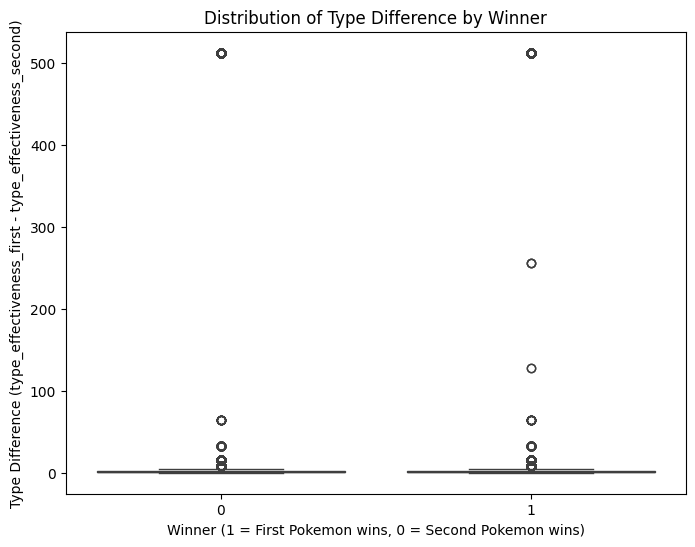

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Winner', y='type_diff', data=df)
plt.title('Distribution of Type Difference by Winner')
plt.xlabel('Winner (1 = First Pokemon wins, 0 = Second Pokemon wins)')
plt.ylabel('Type Difference (type_effectiveness_first - type_effectiveness_second)')
plt.show()

In [ ]:
df.columns

Index(['Type 1_first', 'Type 2_first', 'HP_first', 'Attack_first',
       'Defense_first', 'Sp. Atk_first', 'Sp. Def_first', 'Speed_first',
       'Legendary_first', 'height_first', 'weight_first',
       'base_experience_first', 'Winner', 'Type 1_second', 'Type 2_second',
       'HP_second', 'Attack_second', 'Defense_second', 'Sp. Atk_second',
       'Sp. Def_second', 'Speed_second', 'Legendary_second', 'height_second',
       'weight_second', 'base_experience_second', 'HP_diff', 'Attack_diff',
       'Defense_diff', 'Sp. Atk_diff', 'Sp. Def_diff', 'Speed_diff',
       'base_experience_diff', 'height_diff', 'weight_diff', 'legendary_diff',
       'type_effectiveness_first', 'type_effectiveness_second', 'type_diff'],
      dtype='object')

In [ ]:
model_df = df.loc[:, ~df.columns.str.contains('_first|_second')].copy()


In [ ]:
model_df

,Winner,HP_diff,Attack_diff,Defense_diff,Sp. Atk_diff,Sp. Def_diff,Speed_diff,base_experience_diff,height_diff,weight_diff,legendary_diff,type_diff
0,0,-20,-6,10,-15,10,-19,-59,-4,440,0,0.125
1,0,0,-39,-18,18,39,0,0,1,-600,0,8.000
2,0,-20,-35,10,-45,10,0,-28,-4,-313,0,1.000
3,0,-37,-80,-50,10,-50,-28,-120,-9,-1040,0,0.500
4,1,50,50,-105,105,-160,50,-4,4,145,0,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...
38049,0,5,-38,0,2,0,0,-6,-8,-194,0,1.000
38050,1,70,80,30,80,95,30,247,28,3220,1,0.500
38051,1,25,30,0,-15,5,8,11,1,82,0,512.000
38052,0,-13,-65,40,25,10,-25,-6,-1,-123,0,1.000


# Stop. Prediction Time!

In [ ]:

def run_basic_classifiers(X, y, test_size=0.2, random_state=42):
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        stratify=y,
                                                        random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    accuracies = {}
    confusion_matrices = {}
    predictions = pd.DataFrame(index=X_test.index)

    for name, clf in classifiers.items():
        print(f"Training {name}...")
        # Scale data for models that need it, skip for trees
        if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
        else:
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_test_scaled)

        accuracies[name] = accuracy_score(y_test, y_pred)
        confusion_matrices[name] = confusion_matrix(y_test, y_pred)
        predictions[name] = y_pred

    return accuracies, confusion_matrices


In [ ]:
rez = run_basic_classifiers(model_df.drop(columns=['Winner']), model_df['Winner'])

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training KNN...
Training XGBoost...


In [ ]:
rez

({'Logistic Regression': 0.8831953751149652,
  'Decision Tree': 0.928655892786756,
  'Random Forest': 0.9553278150045986,
  'KNN': 0.8914728682170543,
  'XGBoost': 0.9550650374458022},
 {'Logistic Regression': array([[3603,  425],
         [ 464, 3119]]),
  'Decision Tree': array([[3775,  253],
         [ 290, 3293]]),
  'Random Forest': array([[3836,  192],
         [ 148, 3435]]),
  'KNN': array([[3587,  441],
         [ 385, 3198]]),
  'XGBoost': array([[3825,  203],
         [ 139, 3444]])})

In [ ]:
def display_accuracies(accuracies):
    print("Model Accuracies:")
    for model, acc in accuracies.items():
        print(f"{model}: {acc:.4f}")

display_accuracies(rez[0])

Model Accuracies:
Logistic Regression: 0.8832
Decision Tree: 0.9287
Random Forest: 0.9553
KNN: 0.8915
XGBoost: 0.9551


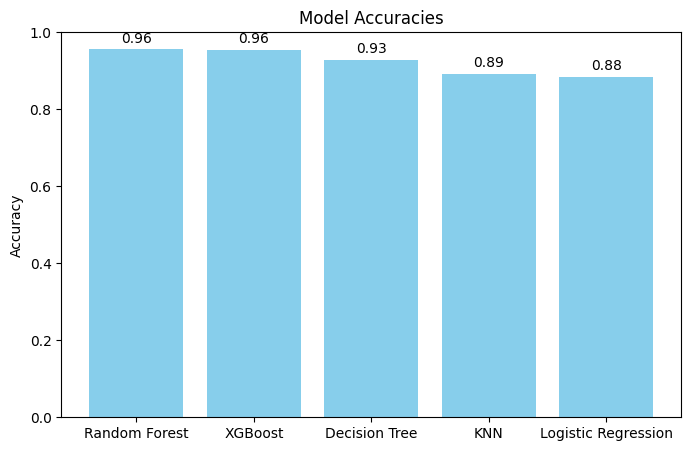

In [ ]:
def plot_accuracies_bar(accuracies):
    # Sort by accuracy descending
    sorted_acc = dict(sorted(accuracies.items(), key=lambda x: x[1], reverse=True))

    plt.figure(figsize=(8,5))
    bars = plt.bar(sorted_acc.keys(), sorted_acc.values(), color='skyblue')
    plt.ylim(0, 1)
    plt.title("Model Accuracies")
    plt.ylabel("Accuracy")

    # Add text labels on top of bars with 2 decimals
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
                 ha='center', va='bottom')

    plt.show()

plot_accuracies_bar(rez[0])

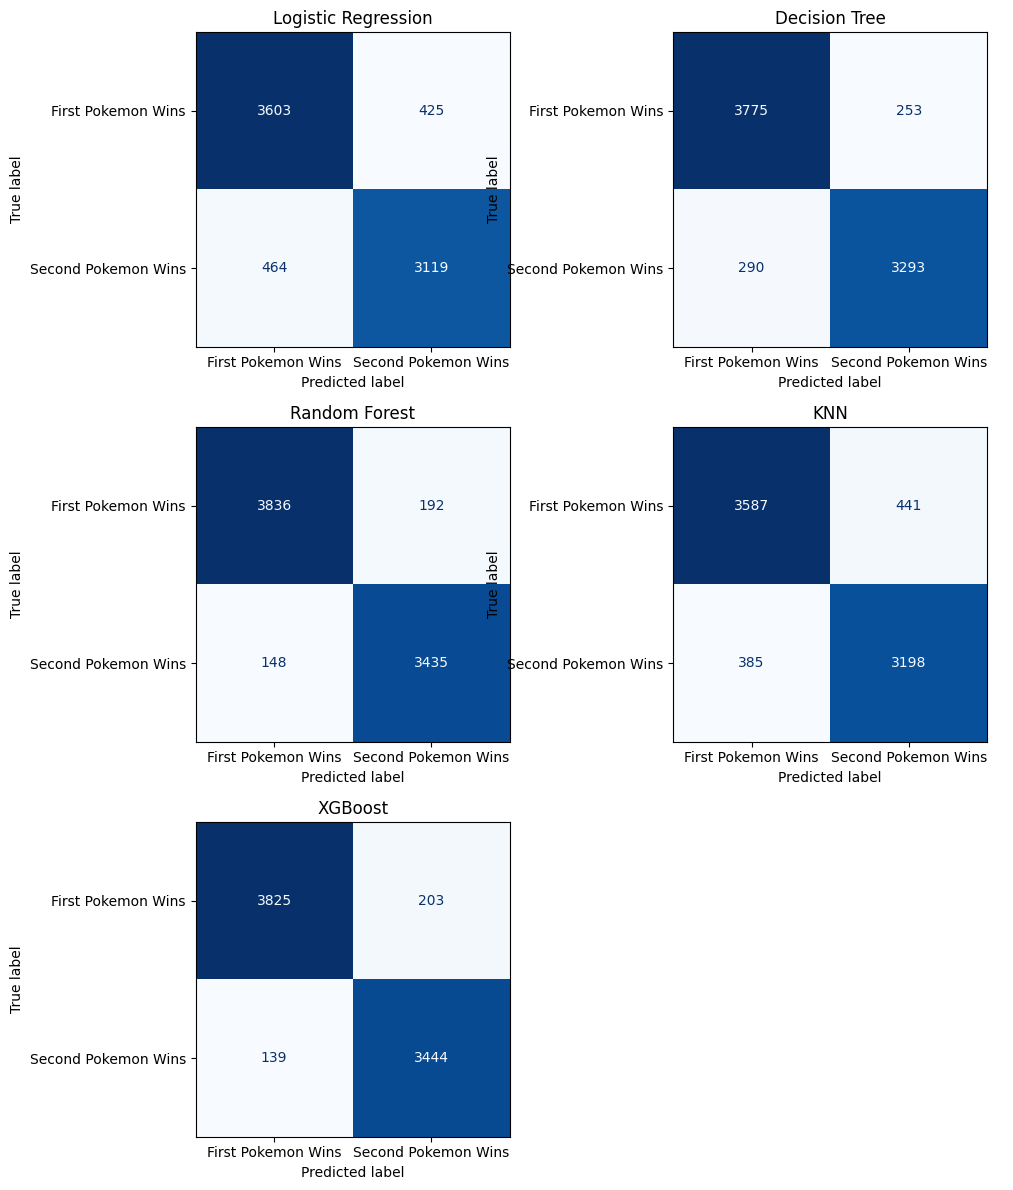

In [ ]:
def plot_confusion_matrices(confusion_matrices, class_names=None):
    n = len(confusion_matrices)
    rows, cols = 3, 2

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    # Turn off any unused axes
    for ax in axes[n:]:
        ax.axis('off')

    for ax, (model, cm) in zip(axes, confusion_matrices.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=ax, cmap='Blues', colorbar=False)
        ax.set_title(model)

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(rez[1], class_names=['First Pokemon Wins', 'Second Pokemon Wins'])


In [ ]:
df['Winner'].value_counts()

,count
Winner,
0,20138
1,17916


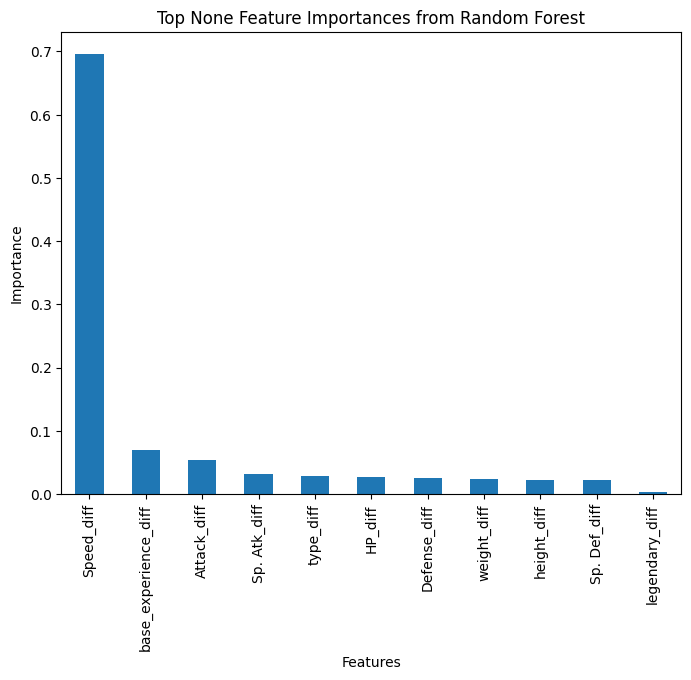

In [ ]:
def plot_rf_feature_importances(rf_model, feature_names, top_n=10):
    importances = rf_model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names)
    feat_imp = feat_imp.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    feat_imp.plot(kind='bar')
    plt.title(f'Top {top_n} Feature Importances from Random Forest')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.show()

    return feat_imp


X, y = model_df.drop(columns=['Winner']), model_df['Winner']

rf = RandomForestClassifier().fit(X, y)
rf_feature_importances = plot_rf_feature_importances(rf, X.columns, top_n=None)